In [ ]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier



In [ ]:
%config InlineBackend.figure_format = 'svg'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Подгружаем данные

In [ ]:
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv

--2021-11-14 17:52:24--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5329268 (5.1M) [text/plain]
Saving to: ‘PD-data-train.csv.4’

PD-data-train.csv.4 100%[===================>]   5.08M  --.-KB/s    in 0.04s   

2021-11-14 17:52:24 (122 MB/s) - ‘PD-data-train.csv.4’ saved [5329268/5329268]

--2021-11-14 17:52:24--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28259 

In [ ]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

Описание данных

In [ ]:
desc_df

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Profit from sales (at the end of the last year),Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Balance of income and expenses (at the end of ...,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Gross Profit (end of last year),Валовая прибыль (на конец последнего года)
8,ar_taxes,Current income tax (at the end of the last year),Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Other income and expenses (at the end of the l...,Прочие доходы и расходы (на конец последнего г...


Семплы и размеры выборок

In [ ]:
test_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg
0,196,39103000.0,38913000.0,38913000.0,0.0,0.0,190000.0,141000.0,331000.0,284000.0,0.0,47000.0,0.0,6009000.0,2451000.0,3558000.0,0.0,677000.0,47000.0,1178000.0,6130000.0,0.0,3000000.0,3130000.0,0.0,156,135,3,3,3,[1-100],100000.0,1,0,0,0
1,1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216,138,5,5,5,[1-100],100000.0,1,0,0,0
2,2813,54174000.0,50929000.0,50929000.0,0.0,0.0,3245000.0,-1278000.0,1967000.0,500000.0,0.0,1467000.0,0.0,8175000.0,8037000.0,138000.0,0.0,237000.0,1467000.0,6835000.0,3906000.0,0.0,0.0,3906000.0,0.0,244,138,20,20,20,[1-100],250000.0,2,0,0,0
3,4385,1904000.0,1679000.0,1679000.0,0.0,0.0,225000.0,-88000.0,137000.0,0.0,0.0,137000.0,0.0,5790000.0,4314000.0,1476000.0,0.0,35000.0,137000.0,5691000.0,540000.0,0.0,500000.0,40000.0,0.0,272,139,9,9,9,[1-100],10000.0,2,0,0,0
4,6479,225584000.0,210685000.0,210685000.0,0.0,0.0,14899000.0,-12715000.0,2184000.0,445000.0,0.0,1739000.0,0.0,65485000.0,46006000.0,19479000.0,0.0,956000.0,1739000.0,12408000.0,47017000.0,0.0,16215000.0,30802000.0,0.0,254,139,3,3,3,(100-500],1700598.0,84,0,0,0


In [ ]:
train_df.shape

(32395, 37)

In [ ]:
test_df.shape

(200, 36)

Количество разных типов фичей

In [ ]:
train_df.dtypes.value_counts()

float64    25
int64      11
object      1
dtype: int64

In [ ]:
train_df['default_12m'].values.mean()

0.06454699799351751

# Бэйзлайн

In [ ]:
def print_scores(matr):
  scores = {}
  scores['precision_1'] = matr[1,1]/(matr[1,0]+matr[1,1]+0.000000001)
  scores['recall_1'] = matr[1,1]/(matr[0,1]+matr[1,1]+0.000000001)
  scores['precision_0'] = matr[0,0]/(matr[1,0]+matr[0,0]+0.000000001)
  scores['recall_0'] = matr[0,0]/(matr[0,1]+matr[0,0]+0.000000001)
  return scores

In [ ]:
features = ['bus_age','ul_capital_sum', 'ul_founders_cnt']

In [ ]:
features_df = train_df.loc[:,features]
features_df['default_12m'] = train_df['default_12m']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_df.drop('default_12m',axis=1),
                                                    features_df['default_12m'],
                                                    random_state=42, shuffle=True)

logit = LogisticRegression(C=1,solver='lbfgs',max_iter=1000)
cv_baseline = cross_val_score(logit, X_train, y_train, cv=5, scoring='roc_auc').mean()
cv_baseline

In [ ]:
logit.fit(X_train, y_train)

In [ ]:
cutoff = y_train.mean()
y_pred_prob = (logit.predict_proba(X_test)[:,1]>cutoff).astype(int)

In [ ]:
y_pred_prob = (logit.predict_proba(X_test)[:,1]>cutoff).astype(int)
conf_matr = confusion_matrix(y_test, y_pred_prob)
print_scores(conf_matr)

# Предобработка данных

## Отбор фич*

Проанализируем дисперсию переменных

In [ ]:
train_df.var().apply(lambda x: '%.5f' % x).sort_values()

ul_systematizing_flg                            0.00000
ul_strategic_flg                                0.00009
default_12m                                     0.06038
ul_branch_cnt                                   0.11745
ab_cash_and_securities            113905440169547.04688
ab_immobilized_assets            1326942722490401.75000
ar_sale_cost                    13378418786211668.00000
ab_inventory                     1391028289002568.50000
ab_accounts_payable              1439389873657956.75000
ab_accounts_receivable           1483653729646988.75000
ar_total_expenses               15060857531859980.00000
ar_selling_expenses               151732610984867.43750
ar_revenue                      16241013203517174.00000
ab_short_term_borrowing           184752306750186.65625
ab_own_capital                   2119181095227624.75000
ogrn_age                                     2164.34622
ab_other_borrowings               223123062009811.34375
ul_capital_sum                    22573201663951

Признак "ul_systematizing_flg" может быть безопасно удалён, так как его дисперсия равна нулю, ul_strategic_flg бинарный признак, равен 1 меньше чем в сотой процента выборки, уберём и его. Также уберём record_id.

In [ ]:
train_df[train_df['ul_strategic_flg']==1].shape[0]

3

In [ ]:
train_df.drop(['record_id', 'ul_systematizing_flg', 'ul_strategic_flg'], axis=1, inplace=True)
test_df.drop(['ul_systematizing_flg', 'ul_strategic_flg'], axis=1, inplace=True)

Замена диапазонов в столбце `ul_staff_range` значениями.


In [ ]:
train_df.ul_staff_range.unique()

array(['[1-100]', '(100-500]', '> 500'], dtype=object)

In [ ]:
ul_staff_range_mappings = {
    '[1-100]': 1,
    '(100-500]': 2,
    '> 500': 3
}

In [ ]:
train_df["ul_staff_range"] = train_df["ul_staff_range"].map(lambda x : ul_staff_range_mappings.get(x, None))

In [ ]:
test_df["ul_staff_range"] = test_df["ul_staff_range"].map(lambda x : ul_staff_range_mappings.get(x, None))

Удалим дубликаты из данных

In [ ]:
train_df.shape

(32395, 34)

In [ ]:
train_df.drop_duplicates(inplace=True, ignore_index=True)

In [ ]:
train_df.shape

(26590, 34)

Посмотрим на коррелирующие колонки и удалим их.

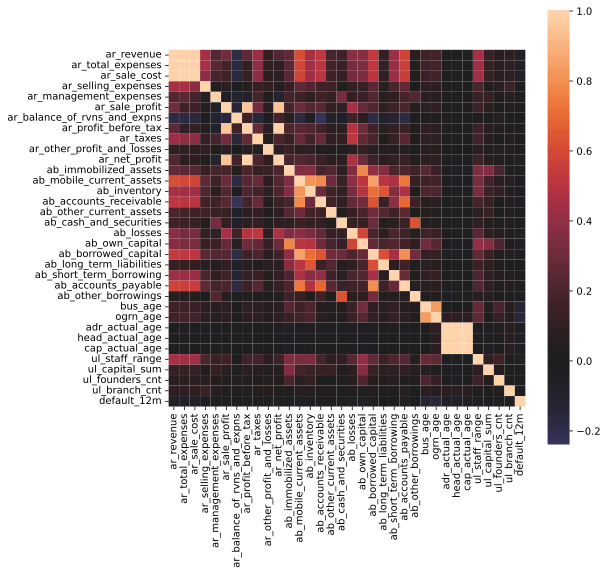

In [ ]:
plt.subplots(figsize=(8,8))
sns.heatmap(train_df.corr(), center=0, square=True)
plt.show()

In [ ]:
to_drop = ['ar_total_expenses',
           'ar_sale_cost',   
           'ar_profit_before_tax',
           'ar_net_profit',
           'head_actual_age',
           'cap_actual_age']

In [ ]:
train_df.drop(to_drop, axis=1, inplace=True)
test_df.drop(to_drop, axis=1, inplace=True)

Можем видеть, что в наборе колонках не хватает одинакового количества рядов, в то время как вдругих колонках данные есть всегда, значит можем выделить две группы данных:
- нетронутые данные (те ряды, где не потеряно ни одно значение)
- дополненные данные

In [ ]:
train_df.isnull().sum()/train_df.shape[0]

ar_revenue                      0.384167
ar_selling_expenses             0.384167
ar_management_expenses          0.384167
ar_sale_profit                  0.384167
ar_balance_of_rvns_and_expns    0.384167
ar_taxes                        0.384167
ar_other_profit_and_losses      0.384167
ab_immobilized_assets           0.384167
ab_mobile_current_assets        0.384167
ab_inventory                    0.384167
ab_accounts_receivable          0.384167
ab_other_current_assets         0.384167
ab_cash_and_securities          0.384167
ab_losses                       0.384167
ab_own_capital                  0.384167
ab_borrowed_capital             0.384167
ab_long_term_liabilities        0.384167
ab_short_term_borrowing         0.384167
ab_accounts_payable             0.384167
ab_other_borrowings             0.384167
bus_age                         0.000000
ogrn_age                        0.000000
adr_actual_age                  0.000000
ul_staff_range                  0.000000
ul_capital_sum  

In [ ]:
test_df.isnull().sum()/train_df.shape[0]

record_id                       0.000000
ar_revenue                      0.004438
ar_selling_expenses             0.004438
ar_management_expenses          0.004438
ar_sale_profit                  0.004438
ar_balance_of_rvns_and_expns    0.004438
ar_taxes                        0.004438
ar_other_profit_and_losses      0.004438
ab_immobilized_assets           0.004438
ab_mobile_current_assets        0.004438
ab_inventory                    0.004438
ab_accounts_receivable          0.004438
ab_other_current_assets         0.004438
ab_cash_and_securities          0.004438
ab_losses                       0.004438
ab_own_capital                  0.004438
ab_borrowed_capital             0.004438
ab_long_term_liabilities        0.004438
ab_short_term_borrowing         0.004438
ab_accounts_payable             0.004438
ab_other_borrowings             0.004438
bus_age                         0.000000
ogrn_age                        0.000000
adr_actual_age                  0.000000
ul_staff_range  

In [ ]:
df_full = train_df.dropna()
df_null = train_df.loc[~train_df.index.isin(df_full.index)]

In [ ]:
df_test_full = test_df.dropna()
df_test_full_ids = df_test_full['record_id']
df_test_full.drop('record_id', axis=1, inplace=True)
df_test_null = test_df.loc[~test_df.index.isin(df_test_full.index)]
df_test_null_ids = df_test_null['record_id']
df_test_null.drop('record_id', axis=1, inplace=True)


Из df_null и df_test_null удалим столбцы, целиком состоящие из None. 

In [ ]:
df_null.dropna(axis='columns', how='all', inplace=True)
df_test_null.dropna(axis='columns', how='all', inplace=True)

In [ ]:
df_null

,bus_age,ogrn_age,adr_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,default_12m
1,256,135,12,1,10000.0,5,0,0
2,33,33,28,1,10000.0,2,0,0
5,100,100,5,1,350000.0,1,0,0
6,266,27,7,1,35000.0,3,0,0
7,31,31,30,1,10000.0,2,0,0
...,...,...,...,...,...,...,...,...
26569,40,40,6,1,10000.0,2,0,0
26571,107,107,19,1,10000.0,1,0,0
26580,136,136,23,1,9408.0,2,0,0
26583,237,139,2,1,161799.0,18,0,0


In [ ]:
df_null.columns.shape, df_test_null.columns.shape, df_full.columns.shape

((8,), (7,), (28,))

В df_null нет потерянных данных больше.

In [ ]:
df_null.isnull().sum()

bus_age            0
ogrn_age           0
adr_actual_age     0
ul_staff_range     0
ul_capital_sum     0
ul_founders_cnt    0
ul_branch_cnt      0
default_12m        0
dtype: int64

In [ ]:
df_test_null.isnull().sum()

bus_age            0
ogrn_age           0
adr_actual_age     0
ul_staff_range     0
ul_capital_sum     0
ul_founders_cnt    0
ul_branch_cnt      0
dtype: int64

In [ ]:
X_null = df_null.loc[:, df_null.columns != 'default_12m']
X_full = df_full.loc[:, df_full.columns != 'default_12m']
y_null = df_null['default_12m']
y_full = df_full['default_12m']


## Преобразование фич

Существуют некоторые эконом фичи, являющиеся отношением других. Модели хорошо способны находить взаимодействие фич на уровне сум-разности и не очень хорошо - на уровне умнож-деления. Поэтому прологарифмируем все фичи - это позволит нам дать модели возможность найти их связь, не добавляя новые фичи самостоятельно. А также это будет неплохим масштабированием. Идея принадлежит @Grigoriy_Milovanov


In [ ]:
for i in X_null.columns:
  min_value = min(df_null[i].min(), df_test_null[i].min()) - 1
  X_null[i] = np.log(X_null[i]- min_value)
  df_test_null[i] = np.log(df_test_null[i]- min_value)

In [ ]:
for i in X_full.columns:
  min_value = min(df_full[i].min(), df_test_full[i].min()) - 1
  X_full[i] = np.log(X_full[i]- min_value)
  df_test_full[i] = np.log(df_test_full[i]- min_value)


Разделим оба датасета на тренировочную и тестовую выборку.

In [ ]:
X_train_null, X_test_null, y_train_null, y_test_null = train_test_split(X_null,y_null,
                                                    random_state=1, shuffle=True)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full,y_full,
                                                    random_state=1, shuffle=True)

# Моделирование

Были рассмотрены логистическая регрессия, случайный лес, кэтбуст классификатор, xgboost, LightGBM, EasyEnesmble классификатор (imblearn). Методом перебора и логики были получены наилучшие модели с точки зрения метрик, интерпретируемости.

**Для X_null: EasyEnsembleClassifier**



In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
  score = cross_val_score(model, X_train, y_train, scoring= 'roc_auc').mean()
  print('ROC-AUC:', score)
  print()

  y_pred = model.predict(X_test)
  print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1'], digits=4))

  sns.heatmap(
    data = pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['0', '1_'],
                 index=['0', '1_']),
            annot=True,
            fmt='g'
            
    )
  plt.show()
  print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['0-exp', '1-exp'],
                 index=['0-machine', '1-machine']))


In [ ]:
easy = EasyEnsembleClassifier(n_estimators = 150,
                              sampling_strategy='all',
                              random_state=1)
easy.fit(X_train_null, y_train_null)

EasyEnsembleClassifier(base_estimator=None, n_estimators=150, n_jobs=1,
                       random_state=1, replacement=False,
                       sampling_strategy='all', verbose=0, warm_start=False)

0.673505783765324

              precision    recall  f1-score   support

     class 0     0.9368    0.6335    0.7558      2270
     class 1     0.1835    0.6585    0.2870       284

    accuracy                         0.6363      2554
   macro avg     0.5602    0.6460    0.5214      2554
weighted avg     0.8530    0.6363    0.7037      2554



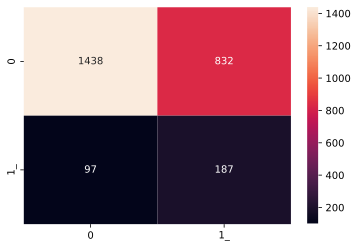

           0-exp  1-exp
0-machine   1438    832
1-machine     97    187


In [ ]:
evaluate_model(easy, X_train_null, y_train_null, X_test_null, y_test_null)

**Для X_full: RandomForestClassifier**

In [ ]:
rfc = RandomForestClassifier(
                        n_estimators=200, min_samples_split=2,
                        class_weight = 'balanced_subsample', max_features='log2',
                        random_state=1)

In [ ]:
rfc.fit(X_train_full, y_train_full)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

0.7214337249820864

              precision    recall  f1-score   support

     class 0     1.0000    0.9996    0.9998     11671
     class 1     0.9919    1.0000    0.9959       610

    accuracy                         0.9996     12281
   macro avg     0.9959    0.9998    0.9979     12281
weighted avg     0.9996    0.9996    0.9996     12281



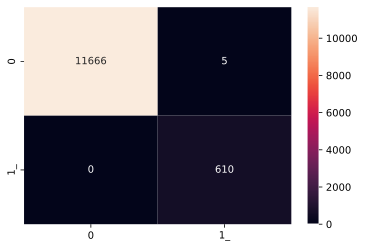

           0-exp  1-exp
0-machine  11666      5
1-machine      0    610


In [ ]:
evaluate_model(rfc, X_train_full, y_train_full, X_train_full, y_train_full)

0.7214337249820864

              precision    recall  f1-score   support

     class 0     0.9639    0.9980    0.9806      3928
     class 1     0.7037    0.1145    0.1969       166

    accuracy                         0.9621      4094
   macro avg     0.8338    0.5562    0.5888      4094
weighted avg     0.9533    0.9621    0.9488      4094



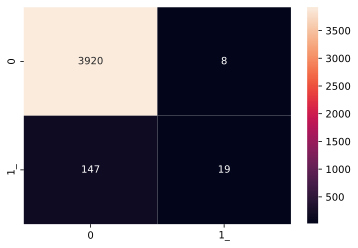

           0-exp  1-exp
0-machine   3920      8
1-machine    147     19


In [ ]:
evaluate_model(rfc, X_train_full, y_train_full, X_test_full, y_test_full)

## Формирование ответа

In [ ]:
rfc.fit(df_full.drop('default_12m', axis=1), df_full['default_12m'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

In [ ]:
easy.fit(df_null.drop('default_12m', axis=1), df_null['default_12m'])

EasyEnsembleClassifier(base_estimator=None, n_estimators=150, n_jobs=1,
                       random_state=1, replacement=False,
                       sampling_strategy='all', verbose=0, warm_start=False)

In [ ]:
predictions_null = easy.predict(df_test_null)
predictions_full = rfc.predict(df_test_full)

In [ ]:
predictions_null_df = pd.DataFrame({
    'id': df_test_null_ids,
    'predict': predictions_null
})
predictions_full_df = pd.DataFrame({
    'id': df_test_full_ids,
    'predict': predictions_full
})

In [ ]:
ans_df =  pd.concat([predictions_null_df, predictions_full_df]) .sort_index()

In [ ]:
ans_df

,id,predict
0,196,0
1,1196,1
2,2813,0
3,4385,0
4,6479,0
...,...,...
195,265577,0
196,266648,1
197,266849,1
198,267566,0


In [ ]:
ans_df.to_csv('PD-submit.csv',index=False, sep=';')

In [ ]:
!cp PD-submit.csv "drive/My Drive/"